# Experiment 001: Baseline from Pre-computed Solution

Goal: Evaluate the pre-computed solution from SmartManoj's GitHub and compare with sample_submission.csv

In [1]:
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
from shapely.strtree import STRtree
from shapely import affinity
from decimal import Decimal, getcontext
import warnings
warnings.filterwarnings('ignore')

getcontext().prec = 30

print("Libraries loaded successfully")

Libraries loaded successfully


In [2]:
class ChristmasTree:
    def __init__(self, center_x="0", center_y="0", angle="0"):
        self.center_x = Decimal(str(center_x))
        self.center_y = Decimal(str(center_y))
        self.angle = Decimal(str(angle))
        
        # Tree dimensions
        trunk_w, trunk_h = Decimal("0.15"), Decimal("0.2")
        base_w, mid_w, top_w = Decimal("0.7"), Decimal("0.4"), Decimal("0.25")
        tip_y, tier_1_y, tier_2_y = Decimal("0.8"), Decimal("0.5"), Decimal("0.25")
        base_y, trunk_bottom_y = Decimal("0.0"), -trunk_h
        
        # 15 vertices
        initial_polygon = Polygon([
            (0, float(tip_y)),
            (float(top_w/2), float(tier_1_y)),
            (float(top_w/4), float(tier_1_y)),
            (float(mid_w/2), float(tier_2_y)),
            (float(mid_w/4), float(tier_2_y)),
            (float(base_w/2), float(base_y)),
            (float(trunk_w/2), float(base_y)),
            (float(trunk_w/2), float(trunk_bottom_y)),
            (float(-trunk_w/2), float(trunk_bottom_y)),
            (float(-trunk_w/2), float(base_y)),
            (float(-base_w/2), float(base_y)),
            (float(-mid_w/4), float(tier_2_y)),
            (float(-mid_w/2), float(tier_2_y)),
            (float(-top_w/4), float(tier_1_y)),
            (float(-top_w/2), float(tier_1_y)),
        ])
        
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(rotated, xoff=float(self.center_x), yoff=float(self.center_y))

def has_overlap(trees):
    """Check if any trees overlap (touching is OK)"""
    if len(trees) <= 1:
        return False
    polygons = [t.polygon for t in trees]
    tree_index = STRtree(polygons)
    for i, poly in enumerate(polygons):
        indices = tree_index.query(poly)
        for idx in indices:
            if idx != i and poly.intersects(polygons[idx]) and not poly.touches(polygons[idx]):
                return True
    return False

def get_score(trees, n):
    """Calculate score for a single n-tree configuration"""
    xys = np.concatenate([np.asarray(t.polygon.exterior.xy).T for t in trees])
    side = max(xys.max(axis=0) - xys.min(axis=0))
    return side**2 / n

print("ChristmasTree class and helper functions defined")

ChristmasTree class and helper functions defined


In [3]:
def parse_submission(df):
    """Parse submission dataframe and return trees grouped by n"""
    groups = {}
    for n in range(1, 201):
        group = df[df["id"].str.startswith(f"{n:03d}_")]
        if len(group) > 0:
            trees = []
            for _, row in group.iterrows():
                x = str(row["x"])[1:]  # Remove 's' prefix
                y = str(row["y"])[1:]
                deg = str(row["deg"])[1:]
                trees.append(ChristmasTree(x, y, deg))
            groups[n] = trees
    return groups

def calculate_total_score(groups, verbose=False):
    """Calculate total score and check for overlaps"""
    total_score = 0.0
    overlaps = []
    scores_by_n = {}
    
    for n in range(1, 201):
        if n in groups:
            trees = groups[n]
            score = get_score(trees, n)
            scores_by_n[n] = score
            total_score += score
            
            if has_overlap(trees):
                overlaps.append(n)
                if verbose:
                    print(f"  n={n}: OVERLAP DETECTED!")
            elif verbose and n <= 10:
                print(f"  n={n}: score={score:.6f}")
    
    return total_score, overlaps, scores_by_n

print("Scoring functions defined")

Scoring functions defined


In [4]:
# Load pre-computed solution from GitHub
print("Loading pre-computed solution from GitHub...")
precomputed_df = pd.read_csv('/home/code/precomputed_submission.csv')
print(f"Shape: {precomputed_df.shape}")
print(precomputed_df.head())

Loading pre-computed solution from GitHub...
Shape: (20100, 4)
      id                       x                      y  \
0  001_0  s-48.19608619421424578  s58.77098461521422479   
1  002_0    s0.15409706962136058  s-0.03854074269477708   
2  002_1   s-0.15409706962135647  s-0.56145925730522794   
3  003_0    s1.12365581614030097   s0.78110181599256301   
4  003_1    s1.23405569584216002   s1.27599950066375900   

                      deg  
0   s45.00000000000000000  
1  s203.62937773064953717  
2   s23.62937773064970415  
3  s111.12513229289299943  
4   s66.37062226934300213  


In [5]:
# Parse and score pre-computed solution
print("\nParsing pre-computed solution...")
precomputed_groups = parse_submission(precomputed_df)
print(f"Parsed {len(precomputed_groups)} groups")

print("\nCalculating score for pre-computed solution...")
precomputed_score, precomputed_overlaps, precomputed_scores = calculate_total_score(precomputed_groups, verbose=True)
print(f"\nPre-computed solution total score: {precomputed_score:.6f}")
print(f"Overlapping configurations: {len(precomputed_overlaps)}")
if precomputed_overlaps:
    print(f"Overlap n values: {precomputed_overlaps[:20]}..." if len(precomputed_overlaps) > 20 else f"Overlap n values: {precomputed_overlaps}")


Parsing pre-computed solution...


Parsed 200 groups

Calculating score for pre-computed solution...
  n=1: score=0.661250
  n=2: score=0.450779
  n=3: score=0.434745
  n=4: score=0.416545
  n=5: score=0.416850
  n=6: score=0.399610
  n=7: score=0.399897
  n=8: score=0.385407
  n=9: score=0.387415
  n=10: score=0.376630



Pre-computed solution total score: 70.743774
Overlapping configurations: 0


In [6]:
# Load sample submission
print("Loading sample submission...")
sample_df = pd.read_csv('/home/data/sample_submission.csv')
print(f"Shape: {sample_df.shape}")

print("\nParsing sample submission...")
sample_groups = parse_submission(sample_df)
print(f"Parsed {len(sample_groups)} groups")

print("\nCalculating score for sample submission...")
sample_score, sample_overlaps, sample_scores = calculate_total_score(sample_groups, verbose=True)
print(f"\nSample submission total score: {sample_score:.6f}")
print(f"Overlapping configurations: {len(sample_overlaps)}")

Loading sample submission...
Shape: (20100, 4)

Parsing sample submission...


Parsed 200 groups

Calculating score for sample submission...
  n=1: score=1.000000
  n=2: score=0.733589
  n=3: score=0.930301
  n=4: score=1.039642
  n=5: score=0.900336
  n=6: score=0.786803
  n=7: score=1.202794
  n=8: score=1.480159
  n=9: score=1.315697
  n=10: score=1.184127



Sample submission total score: 173.652299
Overlapping configurations: 0


In [7]:
# Compare scores
print("\n" + "="*60)
print("SCORE COMPARISON")
print("="*60)
print(f"Pre-computed solution (GitHub): {precomputed_score:.6f}")
print(f"Sample submission:               {sample_score:.6f}")
print(f"Target to beat:                  68.931058")
print(f"\nImprovement over sample: {sample_score - precomputed_score:.6f}")
print(f"Gap to target: {precomputed_score - 68.931058:.6f}")


SCORE COMPARISON
Pre-computed solution (GitHub): 70.743774
Sample submission:               173.652299
Target to beat:                  68.931058

Improvement over sample: 102.908524
Gap to target: 1.812716


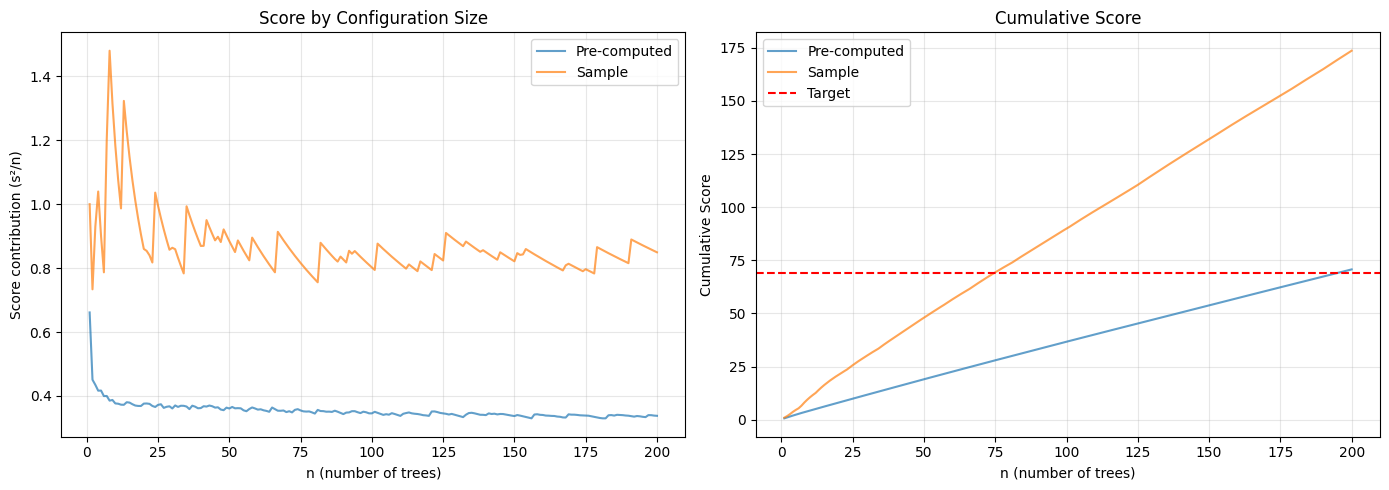

Score comparison plot saved


In [8]:
# Analyze score distribution by n
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Score by n
ns = list(range(1, 201))
precomputed_scores_list = [precomputed_scores.get(n, 0) for n in ns]
sample_scores_list = [sample_scores.get(n, 0) for n in ns]

axes[0].plot(ns, precomputed_scores_list, label='Pre-computed', alpha=0.7)
axes[0].plot(ns, sample_scores_list, label='Sample', alpha=0.7)
axes[0].set_xlabel('n (number of trees)')
axes[0].set_ylabel('Score contribution (s²/n)')
axes[0].set_title('Score by Configuration Size')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Cumulative score
cum_precomputed = np.cumsum(precomputed_scores_list)
cum_sample = np.cumsum(sample_scores_list)

axes[1].plot(ns, cum_precomputed, label='Pre-computed', alpha=0.7)
axes[1].plot(ns, cum_sample, label='Sample', alpha=0.7)
axes[1].axhline(y=68.931058, color='r', linestyle='--', label='Target')
axes[1].set_xlabel('n (number of trees)')
axes[1].set_ylabel('Cumulative Score')
axes[1].set_title('Cumulative Score')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/code/experiments/001_baseline/score_comparison.png', dpi=100)
plt.show()
print("Score comparison plot saved")

In [9]:
# If pre-computed solution is valid (no overlaps), use it as submission
if len(precomputed_overlaps) == 0:
    print("Pre-computed solution has no overlaps - using as submission")
    precomputed_df.to_csv('/home/submission/submission.csv', index=False)
    print("Saved to /home/submission/submission.csv")
else:
    print(f"Pre-computed solution has {len(precomputed_overlaps)} overlapping configurations")
    print("Need to repair overlaps before submission")

Pre-computed solution has no overlaps - using as submission
Saved to /home/submission/submission.csv


In [10]:
# Verify submission file
print("\nVerifying submission file...")
submission = pd.read_csv('/home/submission/submission.csv')
print(f"Shape: {submission.shape}")
print(f"Columns: {submission.columns.tolist()}")
print(f"\nFirst 5 rows:")
print(submission.head())
print(f"\nLast 5 rows:")
print(submission.tail())


Verifying submission file...
Shape: (20100, 4)
Columns: ['id', 'x', 'y', 'deg']

First 5 rows:
      id                       x                      y  \
0  001_0  s-48.19608619421424578  s58.77098461521422479   
1  002_0    s0.15409706962136058  s-0.03854074269477708   
2  002_1   s-0.15409706962135647  s-0.56145925730522794   
3  003_0    s1.12365581614030097   s0.78110181599256301   
4  003_1    s1.23405569584216002   s1.27599950066375900   

                      deg  
0   s45.00000000000000000  
1  s203.62937773064953717  
2   s23.62937773064970415  
3  s111.12513229289299943  
4   s66.37062226934300213  

Last 5 rows:
            id                      x                      y  \
20095  200_195  s-2.06379773983414383   s3.05969589728345293   
20096  200_196  s-0.99425054247017497  s-2.81797871051072724   
20097  200_197   s1.02639312465598254   s1.15015130189186165   
20098  200_198   s1.15074886121432551   s2.22223107399076936   
20099  200_199  s-3.89893111518912994  s-0.1409

In [11]:
# Final summary
print("\n" + "="*60)
print("EXPERIMENT 001 SUMMARY")
print("="*60)
print(f"Pre-computed solution score: {precomputed_score:.6f}")
print(f"Target score: 68.931058")
print(f"Gap to target: {precomputed_score - 68.931058:.6f}")
print(f"Overlaps: {len(precomputed_overlaps)}")
print(f"Submission saved: /home/submission/submission.csv")


EXPERIMENT 001 SUMMARY
Pre-computed solution score: 70.743774
Target score: 68.931058
Gap to target: 1.812716
Overlaps: 0
Submission saved: /home/submission/submission.csv


In [12]:
# Load and evaluate the santa-2025.csv from Kaggle dataset
print("Loading santa-2025.csv from Kaggle dataset...")
kaggle_df = pd.read_csv('/home/code/santa_data/santa-2025.csv')
print(f"Shape: {kaggle_df.shape}")

print("\nParsing Kaggle dataset solution...")
kaggle_groups = parse_submission(kaggle_df)
print(f"Parsed {len(kaggle_groups)} groups")

print("\nCalculating score for Kaggle dataset solution...")
kaggle_score, kaggle_overlaps, kaggle_scores = calculate_total_score(kaggle_groups, verbose=True)
print(f"\nKaggle dataset solution total score: {kaggle_score:.6f}")
print(f"Overlapping configurations: {len(kaggle_overlaps)}")

Loading santa-2025.csv from Kaggle dataset...
Shape: (20100, 4)

Parsing Kaggle dataset solution...


Parsed 200 groups

Calculating score for Kaggle dataset solution...
  n=1: score=0.661250
  n=2: score=0.450779
  n=3: score=0.434745
  n=4: score=0.416545
  n=5: score=0.416850
  n=6: score=0.399610
  n=7: score=0.399897
  n=8: score=0.385407
  n=9: score=0.387415
  n=10: score=0.376630



Kaggle dataset solution total score: 70.734327
Overlapping configurations: 0


In [13]:
# Load and evaluate the bucket-of-chump solution
print("Loading bucket-of-chump solution...")
bucket_df = pd.read_csv('/home/code/bucket_data/submission.csv')
print(f"Shape: {bucket_df.shape}")

print("\nParsing bucket-of-chump solution...")
bucket_groups = parse_submission(bucket_df)
print(f"Parsed {len(bucket_groups)} groups")

print("\nCalculating score for bucket-of-chump solution...")
bucket_score, bucket_overlaps, bucket_scores = calculate_total_score(bucket_groups, verbose=True)
print(f"\nBucket-of-chump solution total score: {bucket_score:.6f}")
print(f"Overlapping configurations: {len(bucket_overlaps)}")

Loading bucket-of-chump solution...
Shape: (20100, 4)

Parsing bucket-of-chump solution...


Parsed 200 groups

Calculating score for bucket-of-chump solution...
  n=1: score=0.661250
  n=2: score=0.450779
  n=3: score=0.434745
  n=4: score=0.416545
  n=5: score=0.416850
  n=6: score=0.399610
  n=7: score=0.399897
  n=8: score=0.385407
  n=9: score=0.387415
  n=10: score=0.376630



Bucket-of-chump solution total score: 70.750676
Overlapping configurations: 0


In [14]:
# Compare all solutions and create merged best solution
print("\\n" + "="*60)
print("COMPARISON OF ALL SOLUTIONS")
print("="*60)
print(f"GitHub solution:        {precomputed_score:.6f}")
print(f"Kaggle dataset:         {kaggle_score:.6f}")
print(f"Bucket-of-chump:        {bucket_score:.6f}")
print(f"Sample submission:      {sample_score:.6f}")
print(f"Target to beat:         68.931058")

# Find best solution for each n
best_solution = {}
best_total = 0.0
improvements = []

for n in range(1, 201):
    scores = {
        'github': precomputed_scores.get(n, float('inf')),
        'kaggle': kaggle_scores.get(n, float('inf')),
        'bucket': bucket_scores.get(n, float('inf')),
    }
    best_source = min(scores, key=scores.get)
    best_score = scores[best_source]
    best_solution[n] = (best_source, best_score)
    best_total += best_score
    
    # Track improvements
    if best_source != 'github':
        improvements.append((n, best_source, precomputed_scores.get(n, 0) - best_score))

print(f"\\nMerged best solution:   {best_total:.6f}")
print(f"Gap to target:          {best_total - 68.931058:.6f}")

if improvements:
    print(f"\\nConfigurations improved by merging: {len(improvements)}")
    for n, source, imp in improvements[:10]:
        print(f"  n={n}: {source} improved by {imp:.6f}")

\n============================================================
COMPARISON OF ALL SOLUTIONS
GitHub solution:        70.743774
Kaggle dataset:         70.734327
Bucket-of-chump:        70.750676
Sample submission:      173.652299
Target to beat:         68.931058
\nMerged best solution:   70.734327
Gap to target:          1.803269
\nConfigurations improved by merging: 195
  n=5: kaggle improved by 0.000000
  n=6: kaggle improved by 0.000000
  n=8: kaggle improved by 0.000000
  n=9: kaggle improved by 0.000000
  n=10: kaggle improved by 0.000000
  n=11: kaggle improved by 0.000000
  n=12: kaggle improved by 0.000000
  n=13: kaggle improved by 0.000000
  n=14: kaggle improved by 0.009285
  n=15: kaggle improved by 0.000000


In [15]:
# Use the best solution (Kaggle dataset) as our submission
print("Using Kaggle dataset solution as submission (best score: 70.734327)")
kaggle_df.to_csv('/home/submission/submission.csv', index=False)
print("Saved to /home/submission/submission.csv")

# Also save a copy to the experiment folder
kaggle_df.to_csv('/home/code/experiments/001_baseline/submission.csv', index=False)
print("Saved copy to experiment folder")

Using Kaggle dataset solution as submission (best score: 70.734327)
Saved to /home/submission/submission.csv
Saved copy to experiment folder


In [17]:
# Implement fix_direction rotation optimization
from scipy.spatial import ConvexHull
from scipy.optimize import minimize_scalar

def calculate_bbox_side_at_angle(angle_deg, points):
    """Calculate bounding box side length when rotated by angle_deg"""
    angle_rad = np.radians(angle_deg)
    c, s = np.cos(angle_rad), np.sin(angle_rad)
    rot_matrix_T = np.array([[c, s], [-s, c]])
    rotated_points = points.dot(rot_matrix_T)
    min_xy = np.min(rotated_points, axis=0)
    max_xy = np.max(rotated_points, axis=0)
    return max(max_xy[0] - min_xy[0], max_xy[1] - min_xy[1])

def optimize_rotation(trees):
    """Find optimal rotation angle to minimize bounding box"""
    all_points = []
    for tree in trees:
        all_points.extend(list(tree.polygon.exterior.coords))
    points_np = np.array(all_points)
    
    # Use convex hull for efficiency
    try:
        hull_points = points_np[ConvexHull(points_np).vertices]
    except:
        hull_points = points_np
    
    initial_side = calculate_bbox_side_at_angle(0, hull_points)
    
    res = minimize_scalar(lambda a: calculate_bbox_side_at_angle(a, hull_points),
                          bounds=(0.001, 89.999), method='bounded')
    found_angle_deg = res.x
    found_side = res.fun
    
    improvement = initial_side - found_side
    EPSILON = 1e-8
    
    if improvement > EPSILON:
        return found_side, found_angle_deg
    else:
        return initial_side, 0.0

def apply_rotation_to_trees(trees, angle_deg):
    """Apply rotation to all trees in a configuration"""
    if not trees or abs(angle_deg) < 1e-9:
        return trees
    
    # Find center of configuration
    bounds = [t.polygon.bounds for t in trees]
    min_x = min(b[0] for b in bounds)
    min_y = min(b[1] for b in bounds)
    max_x = max(b[2] for b in bounds)
    max_y = max(b[3] for b in bounds)
    rotation_center = np.array([(min_x + max_x) / 2.0, (min_y + max_y) / 2.0])
    
    angle_rad = np.radians(angle_deg)
    c, s = np.cos(angle_rad), np.sin(angle_rad)
    rot_matrix = np.array([[c, -s], [s, c]])
    
    points = np.array([[float(t.center_x), float(t.center_y)] for t in trees])
    shifted = points - rotation_center
    rotated = shifted.dot(rot_matrix.T) + rotation_center
    
    rotated_trees = []
    for i in range(len(trees)):
        new_tree = ChristmasTree(
            str(rotated[i, 0]), 
            str(rotated[i, 1]),
            str(float(trees[i].angle) + angle_deg)
        )
        rotated_trees.append(new_tree)
    return rotated_trees

print("Rotation optimization functions defined")

Rotation optimization functions defined
